AI Programming - SW Lee

# Lab 07: Tabular Q Learning
## Exercise: Frozen Lake, Taxi

### Prepare Library Packages

In [1]:
# Check if this code runs in Colab
RunningInCOLAB = 'google.colab' in str(get_ipython())
# if in colab, Use reinforcement learning library gymnasium and tqdm
if RunningInCOLAB:
    !pip install gymnasium
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

In [2]:
#import numpy, matplotlib, gymnasium
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym # name gymnasium as gym
from gymnasium import wrappers # for making video

In [3]:
gym.__version__ #gymnasium library version

'1.0.0'

### Select Environment

**Frozen Lake**<br>
https://gymnasium.farama.org/environments/toy_text/frozen_lake/


**Taxi**<br>
https://gymnasium.farama.org/environments/toy_text/taxi/

**Blackjack**<br>
https://gymnasium.farama.org/environments/toy_text/blackjack/

In [4]:
# select environment
# Text Game:    0 for FrozenLake 4x4, 1 for Taxi, 2 for Blackjack

SELECT_ENV = 1

In [5]:
#classification environments
if SELECT_ENV == 0: # Case FrozenLake
    env_name, res_prefix = 'FrozenLake-v1', 'lak4' # set environment and save prefix
    #set hyperparameters in FrozenLake learning
    max_episodes, max_ep_steps, goal_score = 3000, 500, 0.8
    val_ep_num, lr_rate, discount_rate = 20, 0.8, 0.95
elif SELECT_ENV == 1: # Case Taxi
    env_name, res_prefix = 'Taxi-v3', 'taxi' # set environment and save prefix
    #set hyperparameters in Taxi learning
    max_episodes, max_ep_steps, goal_score = 1000, 500, 8.0
    val_ep_num, lr_rate, discount_rate = 20, 0.8, 0.95
elif SELECT_ENV == 2: # Case Blackjack
    env_name, res_prefix = 'Blackjack-v1', 'blkj' # set environment and save prefix
    #set hyperparameters in Blackjack learning
    max_episodes, max_ep_steps, goal_score = 5000, 10, -0.05
    val_ep_num, lr_rate, discount_rate = 1000, 0.1, 0.95
else: assert False, 'environment selection error' # If it is not a case of 0, 1, 2
# create environment
def create_env():
    if   SELECT_ENV == 0: # Forzen Lake
        env = gym.make(env_name, desc=None, map_name='4x4', is_slippery=True, render_mode='rgb_array') #make FrozenLake environment
    elif   SELECT_ENV == 1: # Taxi
        env = gym.make(env_name, render_mode='rgb_array') #make Taxi environment
    elif   SELECT_ENV == 2: # Blackjack
        env = gym.make(env_name, natural=False, sab=False, render_mode='rgb_array') #make Blackjack environment
    else: pass
    return env

In [6]:
#define enviroment function
def env_reset(env): # initialize observation
    observation = env.reset() #environment reset
    obs = observation[0] if type(observation)==tuple else observation # observation space is tuple or one value
    if SELECT_ENV == 2: # if blackjack
        state = obs[0] + 32 * obs[2] + 64 * obs[1] #observation space has 3-tuple, player's current sum, dealer's one showing card, whether player holds usable ace
    else: state = obs # else just select one value
    return state

def env_step(env, action):
    observation = env.step(action) # Observation according to action, order -> observation, reward,  terminate, trucated, info
    if SELECT_ENV == 2:
        state = observation[0][0] + 32 * observation[0][2] + 64 * observation[0][1] #blackjack state has 3-tuple
    else: state = observation[0]
    reward = observation[1] # reward
    done = observation[2] or observation[3] if len(observation)>4 else observation[2] # Generally, only the terminate argument is given, but consider the case where there is an additional argument indicating the termination status.
    return state, reward, done

In [7]:
# Create variables based on defined functions
env = create_env()
state = env_reset(env)
state, reward, done = env_step(env, env.action_space.sample())

### Check and Show Environment Variables

In [8]:
# Data processing according to action space
action_shape = env.action_space.shape
action_space_type = type(env.action_space)

if action_space_type==gym.spaces.discrete.Discrete: # FrozenLake, Taxi, Blackjack
    actn_space = 'DISCRETE'
    action_shape = (1,)
    action_dims = 1
    action_range = env.action_space.n
    num_actions = action_range  # number of actions is action range for DISCRETE actions
    action_batch_shape = (None, action_range)
elif action_space_type==gym.spaces.box.Box: # Additionally, for action space in box2d format.
    actn_space = 'CONTINUOUS'
    action_dims = action_shape[0]
    actn_uppr_bound = env.action_space.high[0]
    actn_lowr_bound = env.action_space.low[0]
    action_range = (actn_uppr_bound - actn_lowr_bound) # x0.5 for tanh output
    action_batch_shape = tuple([None]+[x for x in action_shape])
    num_actions = action_dims   # number of actions is action dimension for CONTINUOUS actions
else: assert False, 'other action space type are not supported'

# Data processing according to observation space
observation_space_type = type(env.observation_space)
observation_shape = env.observation_space.shape

if observation_space_type==gym.spaces.discrete.Discrete: # FrozenLake, Taxi
    observation_shape = (1,)
    num_states = env.observation_space.n
elif observation_space_type==gym.spaces.box.Box: # Additionally, for observation space in box2d format.
    num_states = observation_shape[0]
elif observation_space_type==gym.spaces.tuple.Tuple: #Blackjack
    observation_shape = tuple([x.n for x in env.observation_space])
    num_states = np.prod(observation_shape) #product
else: print('observation space type error')

if SELECT_ENV == 2: # blackjack state has just one value, player's current sum
    state_shape = (1,)
    state_batch_shape = (None,1)
else:
    state_shape = observation_shape
    state_batch_shape = tuple([None]+[x for x in observation_shape])

value_shape = (1,)
num_values = 1

In [9]:
# Description of current environment
print('Action space ', action_space_type)
print('Action shape ', action_shape)
print('Action dimensions ', action_dims)
print('Action range ', action_range)
if action_space_type==gym.spaces.box.Box:
    print('Max Value of Action ', actn_uppr_bound)
    print('Min Value of Action ', actn_lowr_bound)
else: pass
print('Action batch shape ', action_batch_shape)

print('Observation space ', observation_space_type)
print('Observation shape ', observation_shape)
print('Size of State Space ', num_states)
print('State shape ', state_shape)
print('State batch shape ', state_batch_shape)

print('Vallue shape ', value_shape)
print('Value dimensions ', num_values)

Action space  <class 'gymnasium.spaces.discrete.Discrete'>
Action shape  (1,)
Action dimensions  1
Action range  6
Action batch shape  (None, 6)
Observation space  <class 'gymnasium.spaces.discrete.Discrete'>
Observation shape  (1,)
Size of State Space  500
State shape  (1,)
State batch shape  (None, 1)
Vallue shape  (1,)
Value dimensions  1


### Define and Initialize The Agent
### **Exercise:** Define Q-table (Numpy)

In [10]:
#define q-table for current environment
### START CODE HERE ###

Q_table = np.zeros((num_states,action_range))                          # define q-table

###  END CODE HERE  ###

print(Q_table.shape)

(500, 6)


### Define and Initialize Hyperparameters

In [11]:
#hyperparameter for train
total_episodes = max_episodes   # Total episodes
max_steps = max_ep_steps        # Max steps per episode
learning_rate = lr_rate         # Learning rate
gamma = discount_rate           # Discounting rate
val_episodes = val_ep_num       # number of validation episodes


### Define Epsilon Function

This is an example of exponential decay epsilon function. One of easist epsilon decay functions is simply to multiply 0.9. You can define your own epsilon function.

In [12]:
# Exploration parameters for epsilon greedy strategy
class Epsilon:
    def __init__(self, max_steps):
        self.explore_start = 1.0            # exploration probability at start
        self.explore_stop = 0.01            # minimum exploration probability
        self.decay_rate = 20.0/max_steps    # exponential decay rate for exploration prob (4.6 ~ max_step = 0.01)
        self.steps = 0

    def get_epsilon(self):
        eps = (self.explore_stop
            + (self.explore_start - self.explore_stop) * np.exp(-self.decay_rate * self.steps))
        self.steps += 1
        return eps
# The epsilon value gradually decreases over time, reducing the exploration rate.

### Learning Procedures

Q-learning is an off-policy TD control algorithm.

$$ Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (r_{t} + \gamma \max_{a} Q(s_{t+1},a) - Q(s_t,a_t) ) $$

The target policy $\pi$ is greedy w.r.t. $Q(s,a)$

$$ \pi (s_{t}) = \arg \max_{a^\prime} Q(s_{t},a^\prime) $$

### **Exercise:** Define Training Loop and Evaluation Loop

In [13]:
#For policy evaluate
def evaluate_policy(env, qtable, num_average, images=None):

    total_reward = 0.0
    total_steps = 0
    episodes_to_play = num_average # Works as well as validation episode
    for _ in range(episodes_to_play):                   # Play n episode and take the average
        state = env_reset(env)
        if images!=None: images.append(env.render()) #if image is not None, appending to list
        done = False
        episode_reward = 0.0
        while not done:

            ### START CODE HERE ###

            action = np.argmax(qtable[state,:])                          # get an action from q-table
            next_state, reward, done = env_step(env, action)             # take action and observe outcomes

            ###  END CODE HERE  ###

            if images!=None: images.append(env.render())
            state = next_state                          # update state
            episode_reward += reward
            total_steps += 1
        total_reward += episode_reward
    average_reward = total_reward / episodes_to_play    # take the average reward of evaluations
    average_steps = total_steps / episodes_to_play      # take the average steps of evaluations
    #calculate reward
    return average_reward, average_steps, images


In [14]:
#training
history = {'rewards' : []}                          # logs of rewards
epsF = Epsilon(total_episodes)                      # generate epsilon object

pbar = tqdm(range(total_episodes), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}') # tqdm initializing

for episodes in pbar:

    # initialize variables for a new episode
    epis_rewards = 0                                # episode reward
    epis_steps = 0                                  # steps for an episode
    done = False                                    # episode end flag

    state = env_reset(env)                          # Reset the environment

    epsilon = epsF.get_epsilon()                    # get new epsilon value

    while not done:                                 # simulate to the terminal state of the episode

        ### START CODE HERE ###

        random_number = np.random.uniform(0,1)           # get a random number for exploration decision
        if random_number > epsilon:                      # If this number > greater than epsilon --> exploitation
            action = np.argmax(Q_table[state,:])         #  find an index of the biggest Q value for this state
        else:                                            # Else doing a random choice --> exploration
            action = np.random.randint(0,action_range)          #  get a random integer in [0,action_range)
        next_state, reward, done =  env_step(env,action) # take the action to environment and observe outcomes
        Q_table[state, action] = (1-learning_rate) * Q_table[state, action] + learning_rate * (reward + gamma * np.max(Q_table[next_state,:])) # update q-table

        ###  END CODE HERE  ###

        epis_rewards += reward                      # accumulate rewards to calculate the episode reward
        state = next_state                          # set state for the next state

        if epis_steps > max_steps: break            # if run too much : finish episode
        else: epis_steps += 1

    # evaluate the policy
    eval_reward, eval_steps, _ = evaluate_policy(env, Q_table, val_episodes) # evaluate the policy

    history['rewards'].append(eval_reward) #save reward tendency for ploting

    pbar.set_postfix({'reward':eval_reward, 'steps':eval_steps})

    if eval_reward>goal_score: break                # exit if convergence

print('episodes:{0:5d}, final_reward {1:4.2f}'.format(episodes, eval_reward))

  0%|          | 0/1000 [00:00<?, ?it/s]

episodes:  525, final_reward 8.65


### Plot Training Histories

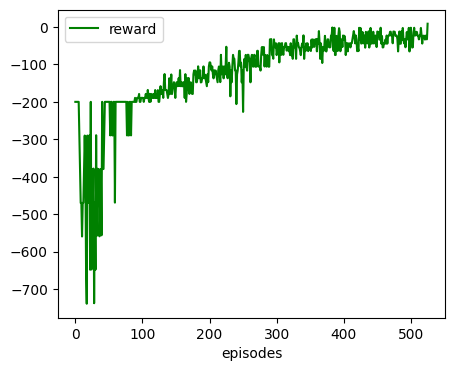

In [15]:
# plot loss and accuracy
def plot_graphs(log_history, log_labels, graph_labels, graph_colors=['b-','g-']):
    num_graphs = len(log_labels)
    plt.figure(figsize=(5*num_graphs,4))
    for i in range(num_graphs):
        plt.subplot(1,num_graphs,i+1)
        plt.plot(log_history[log_labels[i]], graph_colors[i], label=graph_labels[i])
        plt.xlabel('episodes')
        plt.legend()
    plt.show()
    return
# Change in reward according to episode Plot to see the completeness of learning
log_labels    = ['rewards']
label_strings = ['reward']
label_colors  = ['g-']
plot_graphs(history, log_labels, label_strings, label_colors)

### Evaluate the Agent

Evaluate the agent here to show the performance

In [16]:
#agent evaluation
evaluate_episodes = 20
sum_episode_rewards = 0.0
pbar = tqdm(range(evaluate_episodes))

for i in pbar:
    rewards, _, _ = evaluate_policy(env, Q_table, 1) # just one episode
    sum_episode_rewards += rewards

env.close()

print('Evaluation Result:',  sum_episode_rewards/evaluate_episodes)

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation Result: -12.65


## See How The Agent Works

In [17]:
#Measuring reward through actions for each state in the optimized Q-table
env = create_env()

if SELECT_ENV != 2: #for Frozen Lake and Taxi
    env = wrappers.RecordVideo(env, video_folder='./gym-results/', name_prefix=res_prefix) #record video
    eval_reward, _, _ = evaluate_policy(env, Q_table, 1)
else: #for blackjack
    ims = []
    eval_reward, _, ims = evaluate_policy(env, Q_table, 1, ims) # save image

print('Sample Total Reward:', eval_reward)

env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/gym-results folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Sample Total Reward: 3.0


In [18]:
#display agent video
from IPython.display import HTML, display
from base64 import b64encode

def show_video(video_path, video_width = 320):
    video_file = open(video_path, "r+b").read() #read saved video
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}" #encoding decoding
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""") # create link

if SELECT_ENV==2: #create image
    for i in range(len(ims)):
        plt.figure(figsize=(3,3))
        plt.imshow(ims[i])
        plt.show()
else:
    display(show_video('./gym-results/' + res_prefix + '-episode-0.mp4')) #show

(c) 2024 SW Lee